# ZZ Feature Map Algorithm 1 test

### Imports

In [ ]:
#%pip install matplotlib numpy qiskit scipy pandas qiskit_machine_learning

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit import Aer, transpile

from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit.library import StatePreparation

from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import qiskit_machine_learning.kernels
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_blobs

import scipy.io
import pandas as pd
from qiskit.providers.aer import AerError
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.algorithms.state_fidelities import ComputeUncompute
algorithm_globals.random_seed = 0
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import DensityMatrix
from functools import reduce
from sympy import Matrix
from sympy import sqrt as special_sqrt
from qiskit import *
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import Operator

dataset_list = []

## Code used to generate data

Label 1 represents the inlier class, label -1 the outlier class.

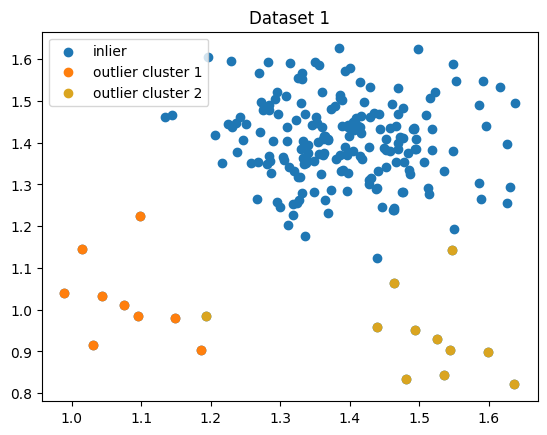

In [24]:
random.seed(13)
seed = 0
x, y = make_blobs(n_samples=190, centers=1, cluster_std=.1, center_box=(1.4, 1.4), random_state=seed)

out1x, out1y = make_blobs(n_samples=9, centers=1, cluster_std=.1, center_box=(1, 1), random_state=seed)
out2x, out2y = make_blobs(n_samples=11, centers=1, cluster_std=.1, center_box=(3.2, 0.01), random_state=seed)

plt.show()

# prepare data for One-Class model
y[y == 0] = 1
out1y[out1y==0] = -1 
out2y[out2y==0] = -1 

x = np.append(x, out1x, axis = 0)
y = np.append(y, out1y, axis = 0)

x = np.append(x, out2x, axis = 0)
y = np.append(y, out2y, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1], label='inlier')
plt.scatter(out1x[:,0], out1x[:,1], label='outlier cluster 1')
plt.scatter(out2x[:,0], out2x[:,1], label='outlier cluster 2', color='goldenrod')

plt.title('Dataset 1')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([x,y])

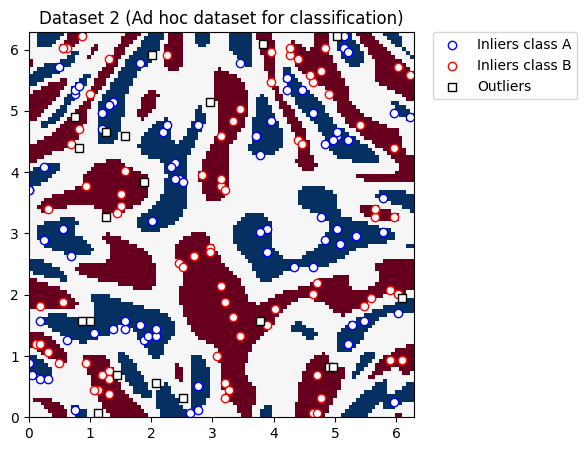

In [32]:
# Second dataset: ZZFeatureMap ad_hoc data
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)
train_features_out, train_labels_out, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
# adhoc_total[adhoc_total == 0] = 1

# print(train_features)
# print(train_labels)

# Change labels for One-Class
train_labels_out[train_labels_out != -1] = -1

# Now we have to add the outliers
train_features = np.append(train_features, train_features_out, axis = 0)
train_labels = np.append(train_labels, train_labels_out, axis = 0)


plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="Inliers class A",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Inliers class B",
)
plt.scatter(
    train_features[np.where(train_labels[:] == -1), 0],
    train_features[np.where(train_labels[:] == -1), 1],
    marker="s",
    facecolors="w",
    edgecolors="k",
    label="Outliers",
)


plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset 2 (Ad hoc dataset for classification)")

plt.show()

# We don't need the second label for one-class SVMs, so change 0 label to 1
train_labels[train_labels == 0] = 1


# add data to dataset_list
dataset_list.append([train_features,train_labels])

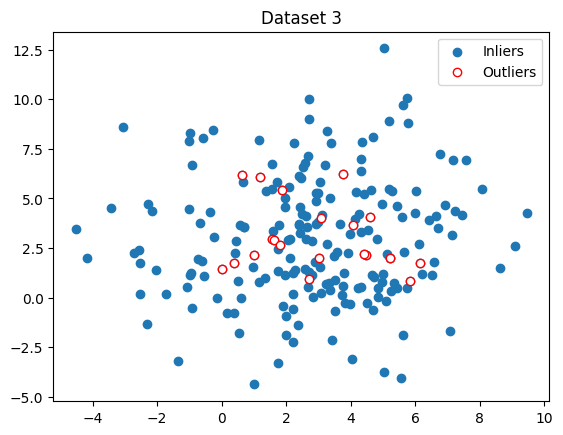

In [33]:
# Third dataset, create blob and add zz feature map data to it
random.seed(13)
seed = 23
x, y = make_blobs(n_samples=190, centers=1, cluster_std=3, center_box=(3, 3), random_state=seed)
train_features_out2, train_labels_out2, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.5,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)

# prepare data for One-Class model
y[y == 0] = 1
train_labels_out2[train_labels_out2 != -1] = -1 

# add outliers to data
x = np.append(x, train_features_out2, axis = 0)
y = np.append(y, train_labels_out2, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1], label='Inliers')
plt.scatter(
    train_features_out2[np.where(train_labels_out2[:] == -1), 0],
    train_features_out2[np.where(train_labels_out2[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Outliers",
)

plt.title('Dataset 3')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([x,y])


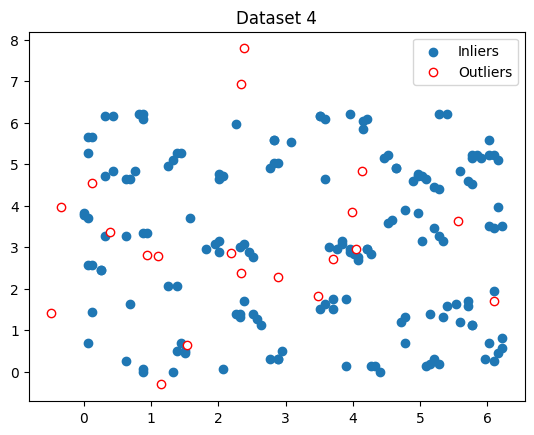

In [47]:
adhoc_dimension = 2
train_features, train_labels, _,_ = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
x, y = make_blobs(n_samples=20, centers=3, cluster_std=2, center_box=(3, 3), random_state=111)

# prepare data for One-Class model
train_labels[train_labels == 0] = 1
y[y != -1] = -1 

# add outliers to data
train_features = np.append(train_features, x, axis = 0)
train_labels = np.append(train_labels, y, axis = 0)

# Plot to see data
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    #marker="o",
    #facecolors="w",
    #edgecolors="b",
    label="Inliers",
)
plt.scatter(
    x[np.where(y[:] == -1), 0],
    x[np.where(y[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Outliers"
)

plt.title('Dataset 4')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([train_features,train_labels])

Save/Load data

In [13]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
def load_object(filename):
    with open(filename, 'rb') as fileload:
        file = pickle.load(fileload)
    return file
# save_object(dataset_list, "datasets")
dataset_list = load_object("datasets")

Custom Feature Maps

In [14]:
def custom_data_map_func(x):
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, x)
    return mapped
def feature_map_superfidel(x):
    # as described in 
    # https://doi.org/10.1103/PhysRevA.97.042315
    
    # Qiskit currently doesn't natively support a square root function in a parameter expression
    # So use sympy base to get the same effect
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, 
                                             np.divide(x,(1-np.square(np.column_stack(x)).trace())._call(special_sqrt)))
    return mapped

Quantum Function for OneClass (Algorithm 1)

In [17]:
# First algorithm, returns trained model
def Algorithm1(X, y, reps=2, shots=1, outliers_fraction=20/210,
               entanglement="linear", num_features = 2, seed = 0, 
               supervised=False, feature_map_no = 1, data_map_no = 1) :
    if feature_map_no == 1:
        # Define ZZFeatureMap using inputs
        if data_map_no == 1:
             feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement)
        elif data_map_no == 2:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = custom_data_map_func)
        elif data_map_no == 3:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = feature_map_superfidel)
    elif feature_map_no == 2:
        # Define ZZFeatureMap using inputs
        feature_map = ZFeatureMap(feature_dimension = num_features, reps = reps)
    elif feature_map_no == 3:
        # Define ZZFeatureMap using inputs
        feature_map = PauliFeatureMap(feature_dimension = num_features, reps = reps)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    # Kernel needs to be evaluated before going into the One-Class SVM
    svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outliers_fraction)
    if supervised: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        # TODO save to Matrix
#         print(classification_report(y_test, y_pred))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

        print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))

        print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))
#         print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
#         print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))

#         print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
#         print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))
    else: 
        svm.fit(X)
        y_pred = svm.predict(X)
        #TODO save to matrix
#         print(classification_report(y, y_pred))
        print("Accuracy: {}".format(accuracy_score(y, y_pred)))

        print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
        
        print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))

#         print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#         print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))

#         print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
#         print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))

    return svm

Showcase of Algorithm 1

In [ ]:
dataset_count = 0
outliers_fraction=20/210
entanglement_list = ["full", 'linear']
data_map_list = []
for X, y in dataset_list:
    dataset_count = dataset_count + 1
    print()
    print("For dataset: {}".format(dataset_count))
    print()
    print("Experiment with number of repetitions 1,2,3")
    for i in range(1,4):
        print("For reps: {}".format(i))
        Algorithm1(X, y, reps=i)
    print()
    print("Experiment with different Feature maps")
    for i in range(1,4):
        print("For feature_map: {}".format(i))
        Algorithm1(X, y, feature_map_no=i)
    print()
    print("Experiment with different entanglements")
    for i in entanglement_list:
        print("For entanglement: {}".format(i))
        Algorithm1(X, y, entanglement=i)
    print()
    print("Experiment with different data_maps")
    for i in range(1,4):
        print("For data_map: {}".format(i))
        Algorithm1(X, y, data_map_no)
    print()
    print("Experiment with different shots")
    for i in range(1,5,2):
        print("For shots: {}".format(i))
        Algorithm1(X, y, shots=i)

# fit data to OneClassSVM
# svm.fit(precomp_kernel_real)


For dataset: 1

Experiment with number of repetitions 1,2,3
For reps: 1
[LibSVM]Accuracy: 0.9095238095238095
Precision 1: 0.9476439790575916
Precision -1: 0.5263157894736842
Recall 1: 0.7263157894736842
F1 1: 0.7314758732081567
For reps: 2
[LibSVM]Accuracy: 0.9238095238095239
Precision 1: 0.9578947368421052
Precision -1: 0.6
Recall 1: 0.7789473684210526
F1 1: 0.7789473684210526
For reps: 3
[LibSVM]Accuracy: 0.8857142857142857
Precision 1: 0.9368421052631579
Precision -1: 0.4
Recall 1: 0.668421052631579
F1 1: 0.668421052631579

Experiment with different Feature maps
For feature_map: 1
[LibSVM]Accuracy: 0.9238095238095239
Precision 1: 0.9578947368421052
Precision -1: 0.6
Recall 1: 0.7789473684210526
F1 1: 0.7789473684210526
For feature_map: 2
[LibSVM]Accuracy: 0.9047619047619048
Precision 1: 0.9473684210526315
Precision -1: 0.5
Recall 1: 0.7236842105263157
F1 1: 0.7236842105263157
For feature_map: 3
[LibSVM]

Comparison to other One-Class SVM methods

In [9]:
other_kernel_list = ['rbf', 'linear', 'poly', 'sigmoid']
outliers_fraction=20/210
dataset_count = 0
supervised = True
for X,y in dataset_list:
    dataset_count = dataset_count + 1
    print()
    print("For dataset: {}".format(dataset_count))
    for kernel in other_kernel_list:
        svm_classical = OneClassSVM(kernel = kernel, verbose=True,  nu=outliers_fraction)
        if supervised:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
            svm_classical.fit(X_train, y_train)
            y_pred = svm_classical.predict(X_test)
            # TODO save to Matrix
            print("{}: ".format(kernel))
#             print(classification_report(y_test, y_pred))
            print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
            
            print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
            print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))
            
            print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
            print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))
            
#             print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))
            
#             print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))

        else:
            svm_classical.fit(X)
            y_pred = svm_classical.predict(X)
            # TODO save to Matrix

            print("{}: ".format(kernel))
#             print(classification_report(y, y_pred))
            print("Accuracy: {}".format(accuracy_score(y, y_pred)))
            
            print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
            print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
            
            print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
            print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))
#             print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))
            
#             print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))




For dataset: 1
[LibSVM]rbf: 
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67         3
           1       1.00      0.92      0.96        39

    accuracy                           0.93        42
   macro avg       0.75      0.96      0.81        42
weighted avg       0.96      0.93      0.94        42

Accuracy: 0.9285714285714286
Precision 1: 1.0
Precision -1: 0.5
Recall 1: 0.9230769230769231
Recall -1: 1.0
F1 1: 0.9600000000000001
F1 -1: 0.6666666666666666
[LibSVM]linear: 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        39

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

Accuracy: 1.0
Precision 1: 1.0
Precision -1: 1.0
Recall 1: 1.0
Recall -1: 1.0
F1 1: 1.0
F1 -1: 1.0
[LibSVM]poly: 
              precision   

C:\Users\slang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\slang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\slang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\slang\anaconda3\lib\site-packages\sklearn\metr

Second algorithm function

In [39]:

def K(x,z, p_constant=1.0):
    return (np.dot(x.T,z)+p_constant)**2

def Algorithm2(X, y, reps, shots, outliers_fraction,entanglement="linear", num_features = 2, seed = 0, supervised=False):
    # Qiskit code for RawFeatureVector has bug, currently not in use
    # TODO We should use RawFeatureVector to stay true to the paper, but Qiskit currently has problem with this method
#     feature_map = RawFeatureVector(feature_dimension = num_features)
#     print(feature_map.parameters)
#     par0 = feature_map.parameters[0]
#     par1 = feature_map.parameters[1]
#     print(par0)
#     print(par1)
#     state = np.array([1, 1]) / np.sqrt(2)
#     feature_map = feature_map.assign_parameters(state)
#     theta_range = np.linspace(0, 2 * np.pi, 128)
#     print(feature_map.parameters)
#     feature_map = feature_map.bind_parameters({par0: 1/np.sqrt(2), par1: 1/np.sqrt(2)})
#     feature_map = ZZFeatureMap(feature_dimension = num_features, reps = reps, entanglement=entanglement)
#     feature_map = ZFeatureMap(feature_dimension = num_features, reps = reps)
#     feature_map = PauliFeatureMap(feature_dimension = num_features, reps = reps)

#     # Calculates probabilities of bit results from quantum circuits
#     sampler = Sampler()
#     # uses sampler to calculate state fidelity of 2 quantum circuits
#     fidelity = ComputeUncompute(sampler=sampler)
#     # Translates data with base state fidelity distance metric
#     kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
#     # Kernel needs to be evaluated before going into the One-Class SVM

#     # Algorithm 2 starts here 
#     svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outliers_fraction)
# #     classical_solution = NumPyLinearSolver().solve(X, y / np.linalg.norm(y))

    # Trick to make matrix hermitian
#     X = np.matrix(X)
#     Xh = X.getH()
#     zeroes1 = np.zeros((X.shape[0], X.shape[0]))
#     zeroes2 = np.zeros((X.shape[1], X.shape[1]))
    
#     X = np.bmat([[zeroes1, X], [Xh, zeroes2]])
#     y = np.append(y, [1,1])
#     X = DensityMatrix(X)
#     np.real(X)
#     print(X)
#     hhl = HHL()
#     hhl.construct_circuit(X,y)
#     inversed_matrix = hhl.solve(X,y)

    # Calculate Kernel Matrix
    K = np.dot(X, np.transpose(X))
    
    # Change Kernel Matrix to density matrix gram
    K_ = np.divide(K, K.trace())
    
    # density matrix exponentiation technique
    # First make matrix hermitian
    K_ = np.matrix(K_)
    K_h = K_.getH()
    zeroes1 = np.zeros((K_.shape[0], K_.shape[0]))
    zeroes2 = np.zeros((K_.shape[1], K_.shape[1]))
    
    hermitian_K = np.bmat([[zeroes1, K_], [K_h, zeroes2]])
#     y = np.append(y, [1,1])
    
    
#     K_dense = DensityMatrix(K_)
#     K_q = Operator(K_)
#     print(K_q)
#     K_q = K_q.to_instruction()
    h = HamiltonianGate(hermitian_K, 1)
    print(len(K_))
    print(len(X))
    return
    # invert Kernel Matrix
    hhl = HHL()
    inversed_matrix = hhl.solve(K_,y)
    
    # Test with custom feature map
    feature_map = PauliFeatureMap(feature_dimension=2, reps=reps, data_map_func=feature_map_superfidel)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outliers_fraction)

    if supervised: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        # TODO save to Matrix
#         print(classification_report(y_test, y_pred))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

        print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))

        print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
        print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))

        print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
        print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))
    else: 
        svm.fit(X)
        y_pred = svm.predict(X)
        #TODO save to matrix
#         print(classification_report(y, y_pred))
        print("Accuracy: {}".format(accuracy_score(y, y_pred)))

        print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))

        print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
        print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))

        print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
        print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))
        
    return svm

Second algorithm attempt

In [40]:
dataset_count = 0
outliers_fraction=20/210

for X, y in dataset_list:
    dataset_count = dataset_count + 1
    print("For dataset: {}".format(dataset_count))
    for i in range(2,3):
        print("For reps: {}".format(i))
        Algorithm2(X, y, i, 1, outliers_fraction=outliers_fraction)
    
    

For dataset: 1
For reps: 2
210
210


C:\Users\slang\AppData\Local\Temp/ipykernel_2268/2593100918.py:95: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  hhl = HHL()


QiskitError: 'The number of rows of the isometry is not a non negative power of 2.'

In [12]:
pwd

'C:\\Users\\slang'